# Analyse astropy table for HoughLines

- author : Sylvie Dagoret-Campagne
- afflilation : LAL/IJCLab, CNRS
- creation date : Fev 26th 2020
- update : 


In [1]:
import os
import re
import numpy as np

In [2]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [4]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import Table

In [5]:
from math import ceil,floor
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle

In [6]:
from astropy.wcs import WCS

In [7]:
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

In [8]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,4)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

In [9]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [10]:
from FeaturesExtractor.config import *
from FeaturesExtractor.features.images import *
from FeaturesExtractor.features.features import *
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

In [11]:
from skimage import feature

In [12]:
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

In [13]:
from scipy import ndimage, misc

In [14]:
#-------------------------------------------------------------------------------------------
def clip_array(in_array,themin,themax):
    amin = np.quantile(in_array, themin)
    amax = np.quantile(in_array, themax)
    out_array = np.clip(in_array, amin, amax)
    return out_array
#-------------------------------------------------------------------------------------------

def clip_array2(in_array,themin,themax):
    amin = np.quantile(in_array, themin)
    amax = np.quantile(in_array, themax)
    out_array = np.where(np.logical_or(in_array<amin,in_array>amax),in_array,-1000)
    return out_array
#-------------------------------------------------------------------------------------------


# Input file

In [15]:
inputfile="../../tests/data/10_CCD1_20200206164429_red.fits"

In [16]:
tablefile="OPTB_lambda_minus_summary_table.txt"

In [17]:
configfile='../../config/opticalbench.ini'

In [70]:
rootname=os.path.basename(inputfile)

# Start

In [18]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [19]:
#--------- Start Logger
my_logger = set_logger("TestCannyEdgesDetection")
my_logger.info('\n\tStart TestCannyEdgesDetection')

2020-02-26 13:14:19  TestCannyEdgesDetection <module>             INFO   
	Start TestCannyEdgesDetection


In [20]:
#--------- Load config file ---------------
load_config(configfile)

In [21]:
#-------- Load reduced image
image = Image(inputfile)

2020-02-26 13:14:19  Image      load_image           INFO   
	Image in file  ../../tests/data/10_CCD1_20200206164429_red.fits loaded


/Users/dagoret/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


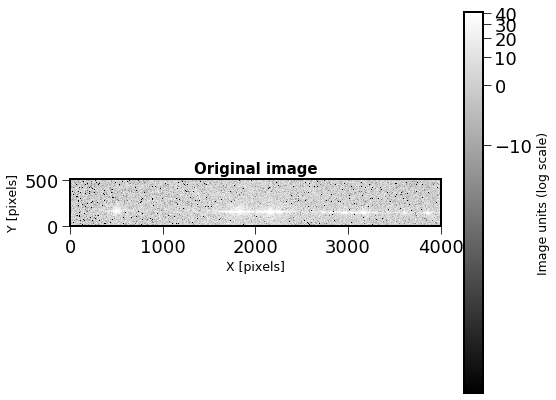

In [22]:
#if parameters.DEBUG and parameters.FLAG_PLOT_IMG :
if parameters.DEBUG  :
    image.plot_image(scale='log',title="Original image",cmap=plt.cm.gray)

In [23]:
img=image.img_cube[parameters.IndexImg.img]

In [24]:
t = Table.read(tablefile,format="ascii")

In [25]:
t.show_in_notebook()

idx,index,length,theta,x1,y1,x2,y2
0,1,1020,-1.010997,2599,156,3619,138
1,2,1459,-0.981668,2151,160,3610,135
2,3,1421,-1.007915,2194,158,3615,133
3,4,852,-1.008624,2665,152,3517,137
4,5,259,-0.884807,2921,143,3180,139
5,6,177,-0.971022,3156,142,3333,139
6,7,337,-1.019995,3007,143,3344,137
7,8,296,-0.967742,2883,143,3179,138
8,9,309,-0.927035,2853,143,3162,138
9,10,450,-0.891196,1819,163,2269,156


In [26]:
thehist=np.histogram(t["theta"],bins=100,range=(-5,5),weights=t["length"],density=True)

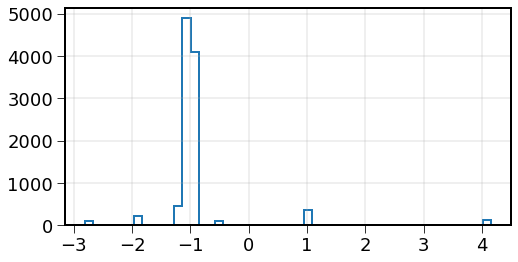

In [27]:
plt.hist(t["theta"],bins=50,weights=t["length"],histtype="step",facecolor="r",lw=2);
plt.grid()

## Create an array to compute median

In [30]:
weights=t["length"]
values=t["theta"]
arr = np.array([])
for idx, w in enumerate(weights):
    x = np.empty(w)
    x.fill(values[idx])
    arr = np.append(arr, x)

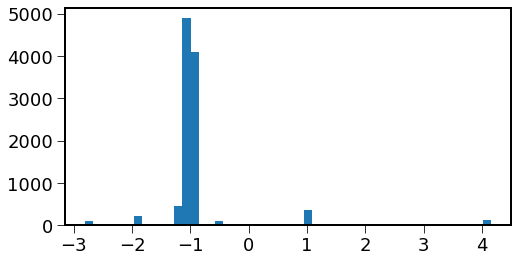

In [31]:
plt.hist(arr,bins=50);

In [32]:
clipped_array=clip_array(arr,0.1,0.9)

In [33]:
filt_array=clipped_array[clipped_array>-1000]

In [34]:
angle_rotation=np.median(filt_array)

In [37]:
angle_rotation

-1.007915

In [49]:
angle_rotation=-0.3

In [50]:
rot_img = ndimage.rotate(img, angle_rotation, reshape=True)

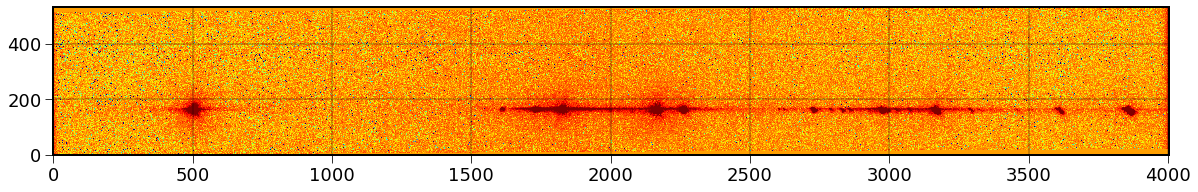

In [52]:
plt.figure(figsize=(20,5))
norm = ImageNormalize(rot_img, interval=PercentileInterval(99), stretch=LogStretch())
plt.imshow(rot_img,origin="lower",cmap="jet",norm=norm)
plt.grid(color="k")

In [53]:
profX=np.sum(rot_img,axis=0)
profY=np.sum(rot_img,axis=1)

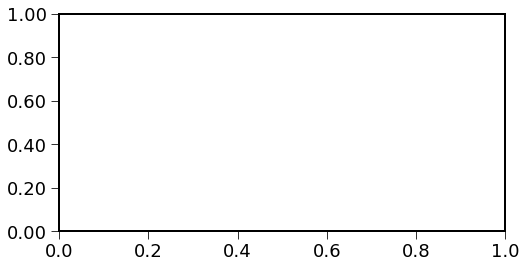

In [76]:
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

/Users/dagoret/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


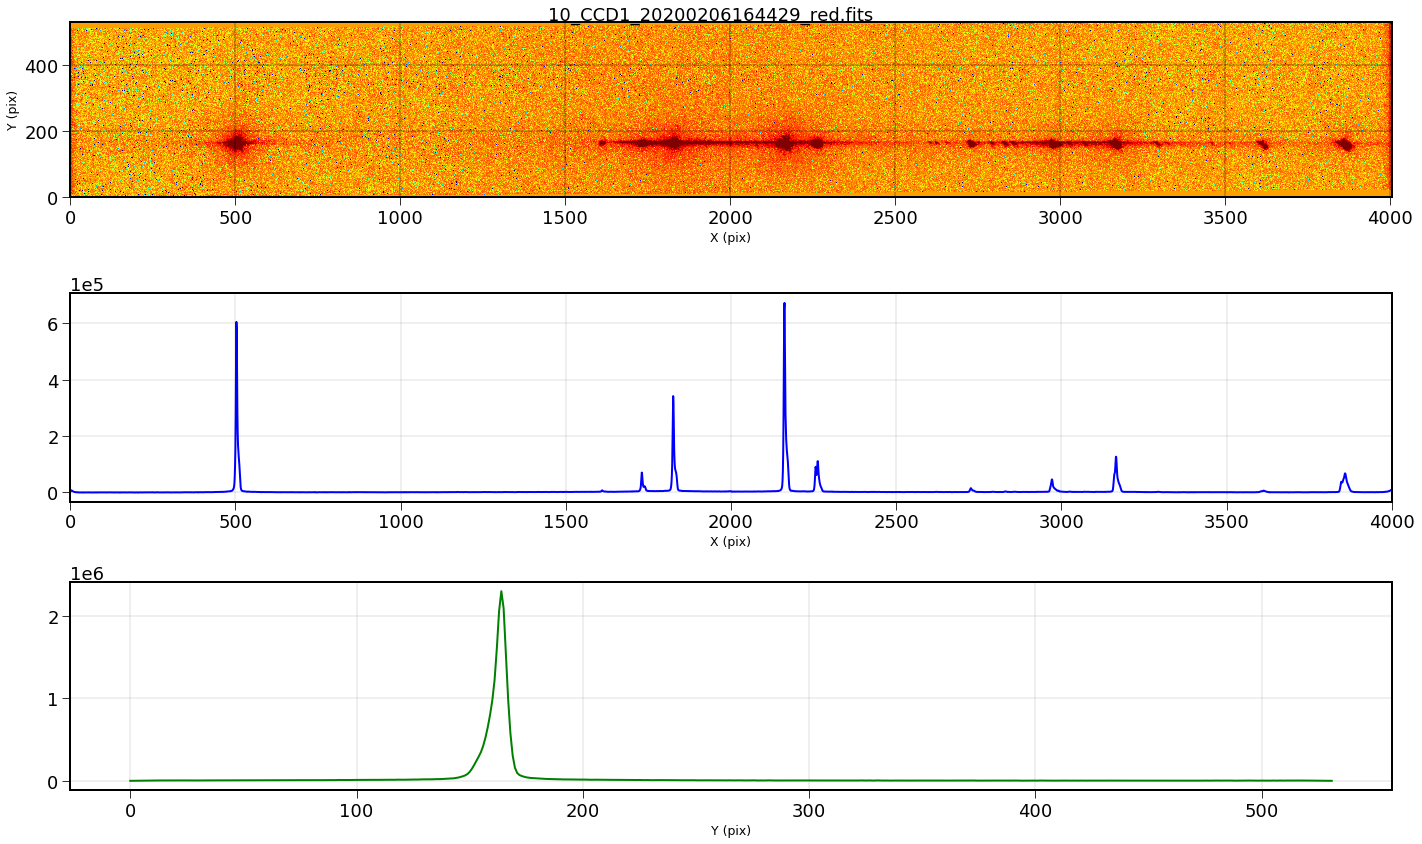

In [91]:
plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
norm = ImageNormalize(rot_img, interval=PercentileInterval(99), stretch=LogStretch())
plt.imshow(rot_img,origin="lower",cmap="jet",norm=norm)
plt.grid(color="k")
plt.xlabel("X (pix)")
plt.ylabel("Y (pix)")
plt.subplot(3,1,2)
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,g}')) # 2 decimal places
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-3,3),useOffset=False)
plt.plot(profX,"b",lw=2)
plt.grid()
plt.xlim(0,4000)
plt.xlabel("X (pix)")
plt.subplot(3,1,3)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-3,3),useOffset=False)
plt.plot(profY,"g",lw=2)
plt.xlabel("Y (pix)")
plt.grid()
plt.tight_layout()
plt.suptitle(rootname)
figname=rootname.split(".")[0]+".png"
plt.savefig(figname)